In [1]:
import json
import os

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc
import pycountry_convert as pcc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:

CYCLE = 10020
# DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
# DOWNSAMPLING = 10
DOWNSAMPLING = 1

In [3]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [4]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [5]:
def geneate_input_filename(date, cycle):

    filename = cfg["paths"]["ark"]["consolidated-long-haul-explorations"].format(date, cycle, DOWNSAMPLING)

    # filenames._create_dir(filename)
    return filename

In [6]:
# def unwrap_lon(x):
#     if x < 40:
#         return  x

#     return -360 + x

In [7]:
def alpha3_to_alpha2(cc3):
    try:
        country = pc.countries.get(alpha_3=cc3)
        return country.alpha_2
    except:
        return "??"


In [8]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

In [9]:
concat_df = pd.read_csv(f"data/processed/snapshots/{CYCLE}.csv.gz", compression="gzip")

In [10]:
def find_rir_level_connectivity(df, target_continent):

    caribbean = ['AI', 'AG', 'AW', 'BS', 'BB', 'BQ', 'KY', 'CU', 'CW',
                 'DM', 'DO', 'GD', 'GP', 'HT', 'JM', 'MQ', 'MS', 'PR',
                 'BL', 'KN', 'LC', 'MF', 'VC', 'SX', 'TT', 'TC', 'VG', 'VI']

    G = nx.from_pandas_edgelist(
       df,
        "near_node_id",
        "far_node_id",
    )

    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_cc"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'cc',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_cc"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'cc',
    )


    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_node_asn"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'asn',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_node_asn"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'asn',
    )

    l = []
    for node in G.nodes():
        country = pc.countries.get(alpha_2=G.nodes[node]["cc"])
        if country.alpha_2 in caribbean:
            continent = "CA"
        else:
            continent = pcc.country_alpha2_to_continent_code(country.alpha_2)

        if continent == target_continent:

            for neighbor_id in G.neighbors(node):
                l.append(
                    (
                        node,
                        G.nodes[node]["cc"],
                        G.nodes[node]["asn"],
                        G.nodes[neighbor_id]["cc"],
                        G.nodes[neighbor_id]["asn"]
                    )
                )


    connectivity = pd.DataFrame(
        l,
        columns=["router_id", "router_cc", "router_asn",
                 "neighbor_cc", "neighbor_asn"]
    )
    return connectivity

In [11]:
def plot_affinity(df, continent, i):
    fig, ax = plt.subplots(1, figsize=(10, 8))

    FONTSIZE = 40

    ax.bar(
        np.arange(1, 10 + 1),
        df.head(10)["router_id"],
        width=1,
        edgecolor="k",
        alpha=0.75,
        color=f"C{i}"
    )

    ax2 = ax.twinx()

    ax2.plot(
        np.arange(1, 10 + 1),
        df.head(10)["cumsum"],
        color="k",
        lw=4,
        marker="o",
        markersize=20,
    )



    ax.set_xticks(np.arange(1, 10 + 1))
    ax.set_xticklabels(df.head(10)["neighbor_cc"].values, rotation=90)

    ax.set_ylabel('# inter-router LHL', fontsize=FONTSIZE)
    ax.set_title(f"{continent}", fontsize=FONTSIZE)
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_xlim(0.5, 10.5)


    ax2.tick_params(labelsize=FONTSIZE)
    ax2.set_ylabel('CDF', fontsize=FONTSIZE)
    ax2.set_ylim(0.0, 1.0)

    fig.subplots_adjust(hspace=0)
    fig.tight_layout()

    # fig.savefig(f"figures/lhls/preferred_foreign_destination_{continent.replace(' ', '_')}.pdf")

In [12]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

-------North America-------
-------South America-------
-------Europe-------
-------Africa-------
-------Asia-------
-------Oceania-------


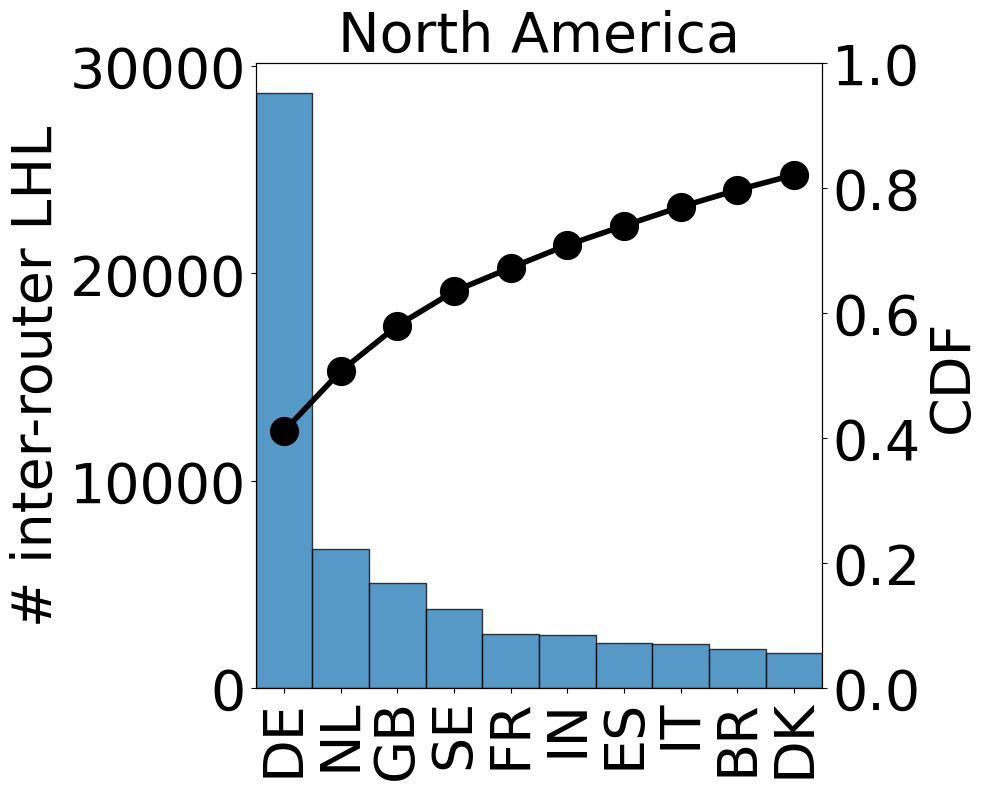

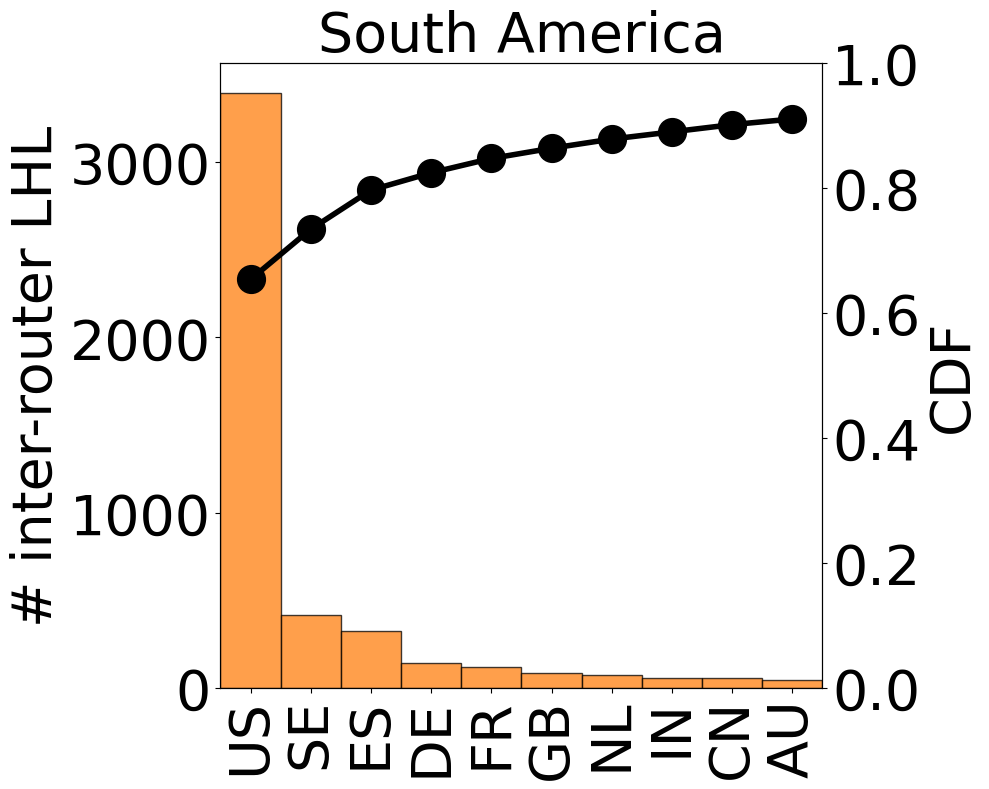

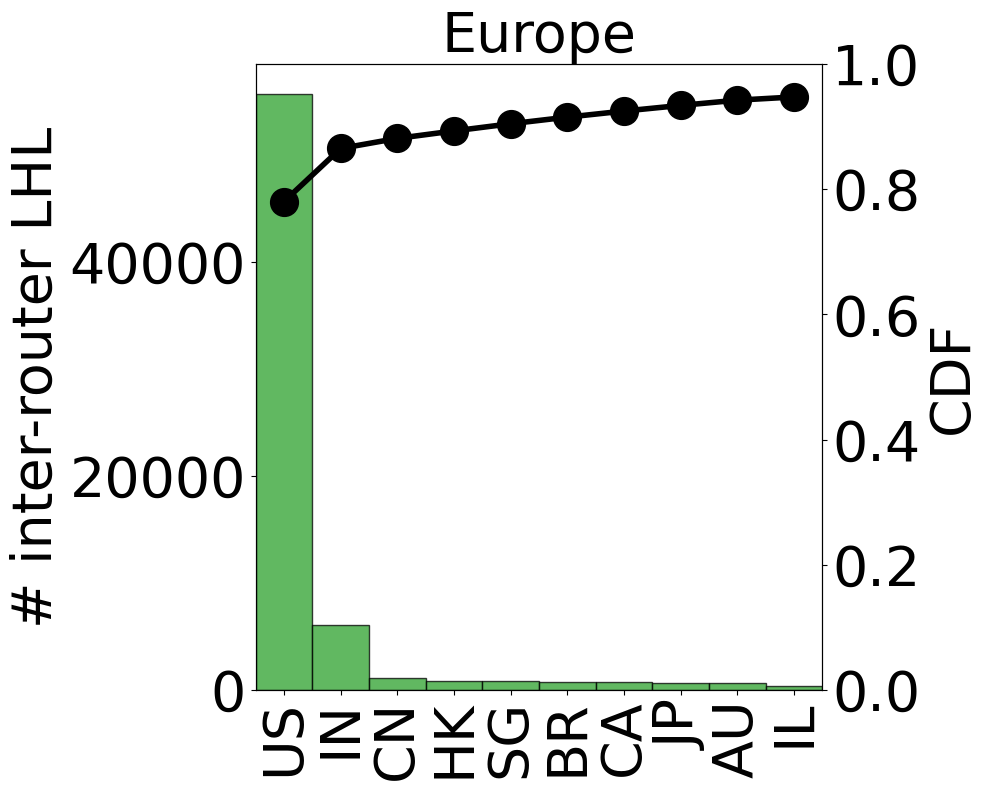

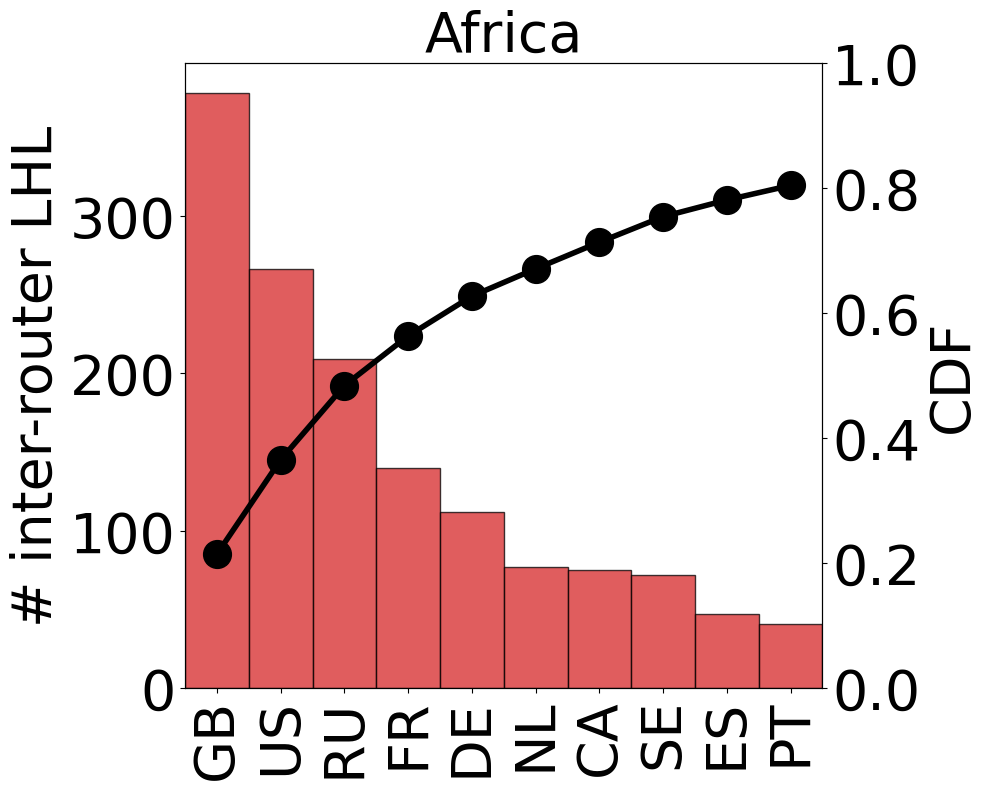

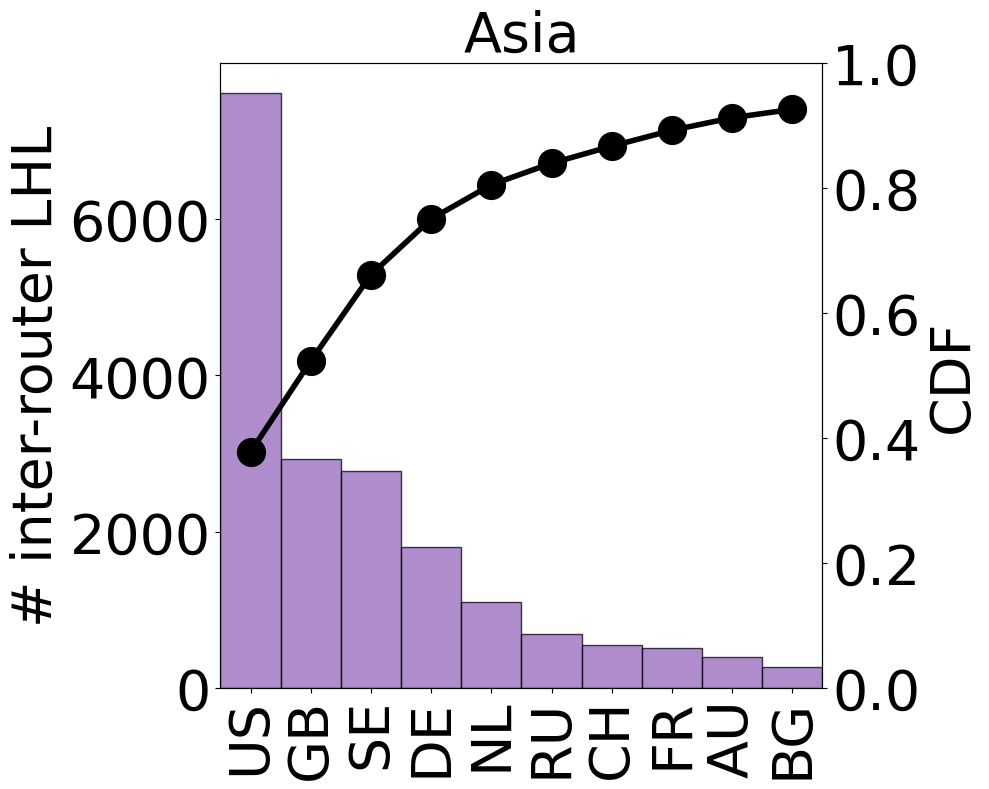

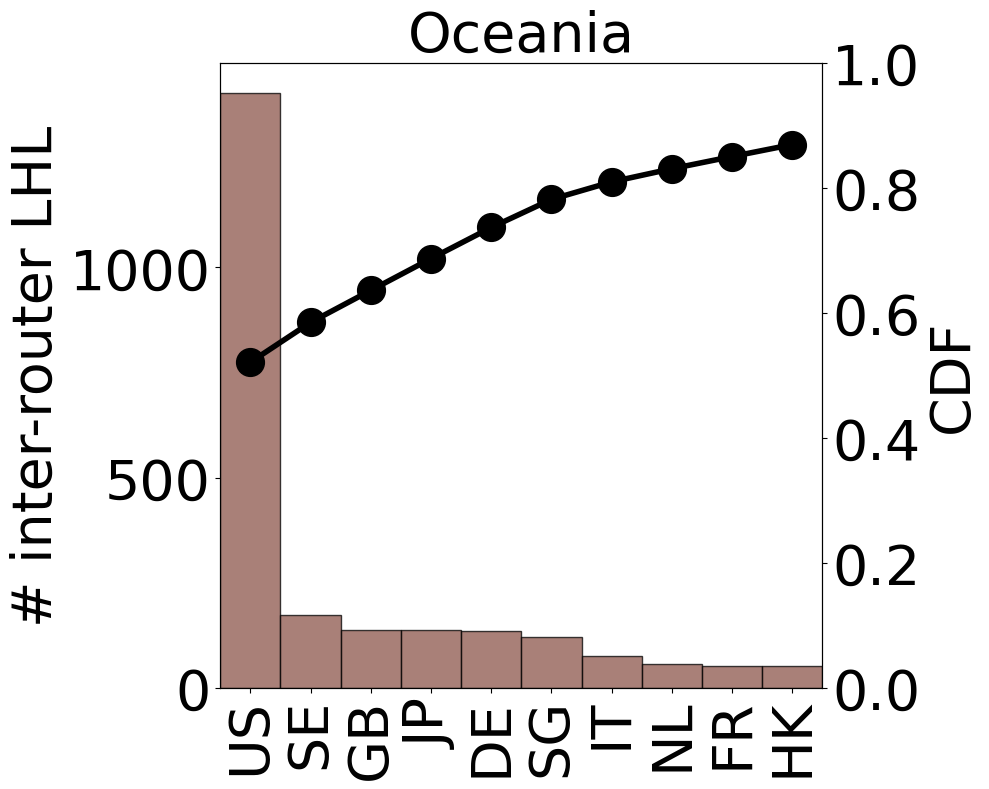

In [13]:

continent_dict = {
    "CA": "Caribbean",
    "NA": "North America",
    "SA": "South America",
    "EU": "Europe",
    "AF": "Africa",
    "AS": "Asia",
    "OC": "Oceania"
}
i = 0
for continent in continent_dict.keys():
    if continent != "CA":
        connectivity = find_rir_level_connectivity(
            concat_df.loc[concat_df["diff_rtt"] > 40],
            continent
        )
        print(f"-------{continent_dict[continent]}-------")
        x = connectivity.groupby("neighbor_cc")["router_id"] \
            .count() \
            .reset_index() \
            .sort_values("router_id", ascending=False)
        t = connectivity.shape[0]
        x["cumsum"] = np.cumsum(x["router_id"]) / t

        plot_affinity(x, continent_dict[continent], i)

        i += 1

In [14]:

continent_dict = {
    "CA": "Caribbean",
    "NA": "North America",
    "SA": "South America",
    "EU": "Europe",
    "AF": "Africa",
    "AS": "Asia",
    "OC": "Oceania"
}
i = 0
for continent in ["AF", ]:
    if continent != "CA":
        connectivity = find_rir_level_connectivity(
            concat_df.loc[concat_df["diff_rtt"] > 40],
            continent
        )
        print(f"-------{continent_dict[continent]}-------")
        x = connectivity.groupby("neighbor_cc")["router_id"] \
            .count() \
            .reset_index() \
            .sort_values("router_id", ascending=False)
        t = connectivity.shape[0]
        x["cumsum"] = np.cumsum(x["router_id"]) / t

        print(x.head())

-------Africa-------
   neighbor_cc  router_id    cumsum
18          GB        378  0.214529
51          US        266  0.365494
42          RU        209  0.484109
17          FR        140  0.563564
13          DE        112  0.627128


In [15]:
0.365494 - 0.214529

0.150965

In [16]:
concat_df.loc[(concat_df["near_side_cc"] == "US") | (concat_df["far_side_cc"] == "US")].shape[0] / concat_df.shape[0] 

0.8040132451179444

In [17]:
def _get_continent(cc):
    if cc == "":
        return ""

    try:
        country = pc.countries.get(alpha_2=cc)
        continent = pcc.country_alpha2_to_continent_code(country.alpha_2)
        return continent
    except:
        return ""

In [18]:
x = concat_df
x["near_side_cont"] = x["near_side_cc"].map(_get_continent)
x["far_side_cont"] = x["far_side_cc"].map(_get_continent)

In [19]:
x.loc[((x["near_side_cont"] == "NA") & (x["far_side_cont"] == "EU")) 
      | ((x["far_side_cont"] == "NA") & (x["near_side_cont"] == "EU"))].shape[0] / x.shape[0]

0.6769869278115452

In [20]:

continent_dict = {
    "CA": "Caribbean",
    "NA": "North America",
    "SA": "South America",
    "EU": "Europe",
    "AF": "Africa",
    "AS": "Asia",
    "OC": "Oceania"
}

conts = np.sort(list(continent_dict.keys()))

continent_stats = []
cont_labels=[]

for continent in conts:
    if continent != "CA":
        
        cont_labels.append(continent)
        
        connectivity = find_rir_level_connectivity(
            concat_df.loc[concat_df["diff_rtt"] > 57],
            continent
        )
        
        connectivity["neighbor_continent"] = connectivity["neighbor_cc"].map(_get_continent)
        
        
        x = connectivity.groupby("neighbor_continent") \
            ["neighbor_asn"] \
            .count() \
            .reset_index()
        
        x = pd.concat([x, pd.DataFrame([[continent, 0]], columns=["neighbor_continent", "neighbor_asn"])])
        
        x = x.sort_values("neighbor_continent")
        
        continent_stats.append(x["neighbor_asn"].values.tolist())

In [21]:
continent_stats

[[0, 175, 1156, 342, 20, 69],
 [175, 0, 11395, 7877, 457, 257],
 [1156, 11395, 0, 56819, 739, 1334],
 [342, 7850, 56715, 0, 1444, 3466],
 [20, 457, 739, 1447, 0, 51],
 [69, 257, 1334, 3482, 51, 0]]

In [22]:
x = pd.DataFrame()
for continent in conts:
    if continent != "CA":
        
        cont_labels.append(continent)
        
        connectivity = find_rir_level_connectivity(
            concat_df.loc[concat_df["diff_rtt"] > 57],
            continent
        )
        
        connectivity["router_cont"] =  connectivity["router_cc"].map(_get_continent)
        connectivity["neighbor_cont"] =  connectivity["neighbor_cc"].map(_get_continent)
        
        x = pd.concat([x, connectivity])

In [23]:
cont = x.groupby(['router_cont', 'neighbor_cont'])["router_asn"] \
           .count() \
           .reset_index() \
           .sort_values("router_asn", ascending=False)

cont = cont.rename(columns = {'router_asn':'cnt',})

In [24]:
cont["router_cont"] = [f' {r}' for r in cont["router_cont"].values]

In [25]:
x = concat_df.drop_duplicates(["near_node_id", "far_node_id",])

In [26]:
x["near_side_cont"] =  x["near_side_cc"].map(_get_continent)
x["far_side_cont"] =  x["far_side_cc"].map(_get_continent)

/tmp/ipykernel_457694/2850860162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["near_side_cont"] =  x["near_side_cc"].map(_get_continent)
/tmp/ipykernel_457694/2850860162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["far_side_cont"] =  x["far_side_cc"].map(_get_continent)


In [27]:
cont = x.groupby(['near_side_cont', 'far_side_cont'])["diff_rtt"] \
           .count() \
           .reset_index() \
           .sort_values("diff_rtt", ascending=False)

cont = cont.rename(columns = {'diff_rtt':'cnt',})

In [28]:
cont["near_side_cont"] = [f' {r}' for r in cont["near_side_cont"].values]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
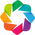

In [29]:
import holoviews as hv
hv.extension("bokeh")

In [30]:
# https://stackoverflow.com/questions/60263233/holoviews-font-change
def hook(plot, element):
    plot.handles['text_1_glyph'].text_font = 'arial'
    plot.handles['text_1_glyph'].text_font_size = '16pt'
#     plot.handles['text_2_glyph'].text_font = 'arial'
#     plot.handles['text_2_glyph'].text_font_size = '16pt'

In [31]:
sankey1 = hv.Sankey(cont, kdims=['near_side_cont', 'far_side_cont'], vdims=["cnt"])

## Modifying Default Chart Options
sankey1.opts(cmap='Colorblind',
             label_position='left',
             edge_color='near_side_cont', edge_line_width=0,
             node_alpha=1.0, node_width=40, node_sort=True,
             width=800, height=600,
             # dpi=3000,
             hooks=[hook])

:Sankey   [near_side_cont,far_side_cont]   (cnt)

In [32]:
43800 / (43800 + 18288 + 16788 + 4299 + 1573 + 1038)

0.5105728207399809